実行したいセルに単語を入力したあと、Ctrl + Enter で実行してください。
> わからないことがあったら気軽に質問してください。

# 日本語の Wikipedia の記事で学習した単語分散表現
このデモでは、人工知能によって「ベクトル」に変換された「単語」を使って、その「ベクトル」がどのように「単語」の特徴をとらえているかを見ていきます。

## ライブラリのインストール

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager 
import gensim
import seaborn as sns
import cv2
from os import path
from scipy import signal
from scipy import misc
sns.set()
plt.rcParams["font.family"] = 'IPAexGothic'

## 単語ベクトルを見てみる
まずは単語がどのようにベクトルによって数値表現されているか見てみましょう。

In [5]:
# 単語分散表現を読み込む

vec = gensim.models.KeyedVectors.load_word2vec_format('/home/okazaki/install/jawiki.bin', binary=True, unicode_errors='ignore')

In [6]:
vec['栃木県']

array([-0.26552305, -0.26967752,  0.27101582, -0.38676125,  0.28956363,
       -0.34571406, -0.08944321,  0.5598806 ,  0.1915539 ,  0.28988597,
        0.2093499 ,  0.14678925, -0.26350775, -0.03260737, -0.39187533,
       -0.24516748,  0.4200362 , -0.42514825,  0.42286307, -0.2391351 ,
        0.11768519, -0.27497014, -0.07275463,  0.09183327,  0.7495942 ,
       -0.01504772,  0.04234359, -0.08572177,  0.06288831,  0.14221872,
        0.00715072, -0.44587815,  0.03074083, -0.38795695,  0.06102454,
       -0.60135627, -0.01541477,  0.17472826, -0.3274164 ,  0.3798543 ,
       -0.03324236, -0.37610173, -0.4736631 ,  0.00677247,  0.274242  ,
        0.5183447 ,  0.20519096, -0.4735934 ,  0.20236918,  0.15901533,
        0.06514866,  0.22686465,  0.5596911 , -0.2185093 , -0.3232636 ,
        0.475059  , -0.10012705,  0.15919709, -0.23005244, -0.05910872,
        0.3271913 ,  0.25205508,  0.16818942, -0.39117637,  0.417262  ,
        0.08676066, -0.04379294,  0.14442772, -0.16918923, -0.32

In [7]:
# len() によってベクトルの長さを測る

len(vec['栃木県'])

256

In [8]:
# 単語ベクトルを描画する関数を作る

def plot_vector(x):
    plt.xlim(0, len(x))
    plt.plot(range(len(x)), x, 'b')

ベクトルをグラフで表現してみます。一番左が1次元目の数値、一番右が256次元目の数値に対応しています。

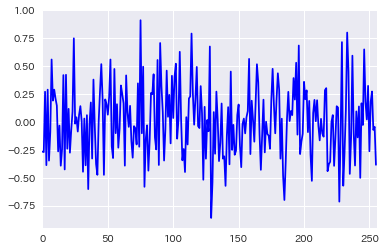

In [9]:
plot_vector(vec['栃木県'])

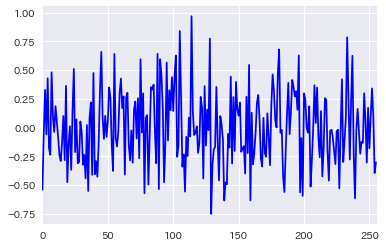

In [10]:
plot_vector(vec['茨城県'])

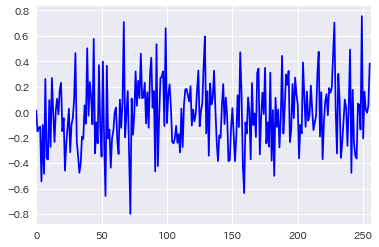

In [11]:
plot_vector(vec['水'])

「栃木県」と「茨城県」のベクトルが似ていて、「水」はそれらと違う波形になっているような気がします。

ヒートマップと呼ばれる形式でも比較してみましょう。

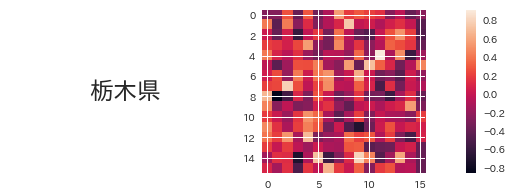

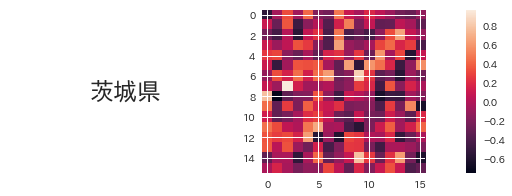

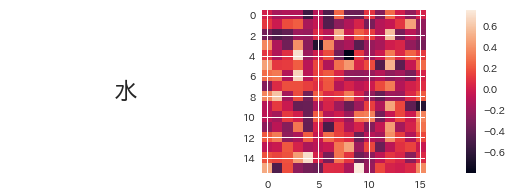

In [32]:
def print_vec(word, shape=(16,16)):
    vector = vec[word]
    vec_img = np.reshape(vector, shape)
    fig, (ax1, ax2,cax) = plt.subplots(ncols=3,figsize=(8,3), 
                  gridspec_kw={"width_ratios":[1,1, 0.05]})    
    ax1.text(0.5, 0.5, word, horizontalalignment='center', verticalalignment='center', fontsize=24)
    ax1.axis('off')
    im = ax2.imshow(vec_img)
    plt.colorbar(im, cax=cax)
    plt.show()
    

def vec_similarity(word1, word2, shape=(16,16)):
    vector1 = vec[word1]
    vector2 = vec[word2]
    val = vec.similarity(word1, word2)
    vec_img1 = np.reshape(vector1, shape)
    vec_img2 = np.reshape(vector2, shape)
    fig, (ax1, ax2, ax3, cax) = plt.subplots(ncols=4,figsize=(8,3), 
                  gridspec_kw={"width_ratios":[1,0.4,1, 2]})   
    
    
    
    ax1.imshow(vec_img1)
    ax1.axis('off')
    ax1.set_title('A', fontsize=24)
    
    ax2.text(0.5, 0.5, "と", horizontalalignment='center', verticalalignment='center', fontsize=24)
    ax2.axis('off')
    
    ax3.imshow(vec_img2)
    ax3.axis('off')
    ax3.set_title('B', fontsize=24)
    
    cax.text(0.5, 0.5, "類似度： " + str(round(val,4)), horizontalalignment='center', verticalalignment='center', fontsize=24)
    cax.axis('off')
    
    plt.show()
    
    
print_vec('栃木県')
print_vec('茨城県')
print_vec('水')    


## ふたつの単語ベクトルがどれくらい似てるか計算する

今度はふたつの単語がどれくらい似ているかを計算してみます。計算には「コサイン類似度」を使います。

ふたつのベクトル

\begin{equation}
\vec{a} = (a_1, a_2, \cdots, a_n) \\
\vec{b} = (b_1, b_2, \cdots, b_n)
\end{equation}
に対して

\begin{equation}
cos(\vec{a},\vec{b})
= \frac{\vec{a} \cdot \vec{b}}{|a||b|}
= \frac{a_1 b_1 + \cdots + a_n b_n}{\sqrt{a_{1}^2 + \cdots + a_{n}^2}\sqrt{b_{1}^2 + \cdots + b_{n}^2}}
\end{equation}

をコサイン類似度と言います。

この式は直感的には、ふたつのベクトルのなす角がどれくらい小さいか（つまり、どれくらい同じ方向を向いているか）を表しています。

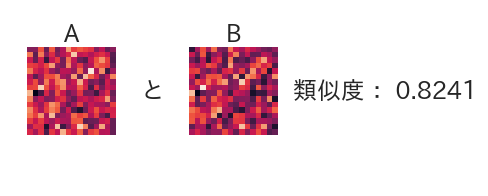

In [33]:
vec_similarity('栃木県', '茨城県')

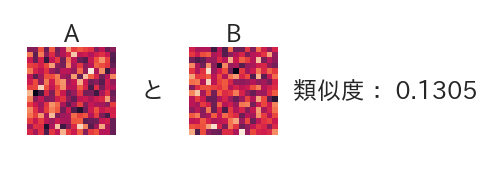

In [34]:
vec_similarity('栃木県', '水')

## 似てる単語を調べる

*most_similar()* 関数は、与えた単語のコサイン類似度を計算して、類似度が高い単語を出力してくれます。

In [31]:
vec.most_similar(positive=['栃木県'])

[('群馬県', 0.8336408734321594),
 ('茨城県', 0.8241381049156189),
 ('埼玉県', 0.7634727358818054),
 ('福島県', 0.7543847560882568),
 ('千葉県', 0.7479901313781738),
 ('山梨県', 0.7404770255088806),
 ('下都賀郡', 0.7402663230895996),
 ('山形県', 0.7265231609344482),
 ('秋田県', 0.7081300616264343),
 ('岩手県', 0.7017161846160889)]

In [22]:
vec.most_similar(positive=['水'])

[('水屋', 0.7254225015640259),
 ('真水', 0.6765139102935791),
 ('塩水', 0.6725157499313354),
 ('手水', 0.6722308397293091),
 ('流水', 0.6679975390434265),
 ('くみ出す', 0.659170925617218),
 ('地下水', 0.654391348361969),
 ('わき水', 0.6527077555656433),
 ('エアレーション', 0.6519521474838257),
 ('中水', 0.6499719023704529)]

In [ ]:
vec.most_similar(positive=['コンピュータ'])

In [ ]:
vec.most_similar(positive=['嬉しい'])

In [ ]:
vec.most_similar(positive=['さんま'])

In [ ]:
vec.most_similar(positive=['サンマ'])

In [ ]:
vec.most_similar(positive=[''])

## 単語ベクトルを足し引きしてみる

最後に、単語を足し引きしてみたいと思います。

$宇都宮 - 栃木県 + 茨城県$

を計算すると、結果のベクトルはどなるのでしょうか？

In [ ]:
vec['栃木県']

In [ ]:
vec['宇都宮'] - vec['栃木県'] + vec['茨城県']

In [ ]:
vec.similar_by_vector(vec['宇都宮'] - vec['栃木県'] + vec['茨城県'])

In [ ]:
vec.similar_by_vector(vec['宇都宮'])

In [ ]:
vec.most_similar(positive=['東京', 'アメリカ'], negative=['日本'])

In [ ]:
vec.most_similar(positive=['のび太', 'ピカチュウ'], negative=['ドラえもん'])

In [ ]:
vec.most_similar(positive=['', ''], negative=[''])